<a href="https://colab.research.google.com/github/mwz773/Deepmind_ResearchProject/blob/main/Fall_Research_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024 Fall Research Report

This report details my research under the mentorship of Revant Teotia in which I developed a rudimentary image classifier for images that have undergone a Fourier transformation. This application can be used to classify MRI spatial images, by directly taking MRI k-space to feed into the classifier for medical diagnoses and other healthcare applications.


We detail three main parts of the research:


1. Classification Basics
2. Converting spatial frequencies to k-spaces with PyTorch FFT
3. Training an image classifier on 2-channel k-space images



# Classification Basics

In the beginnings of my research, Revant suggested I brush up on classification models and machine learning basics, which I detail below:

### Image Representation
Images are represented with **tensors**, multi-dimensional arrays:
*    Grayscale images are represented as 2D matrices, which each element corresponding to the intensity of a pixel.
*   Color images are represented as 3D matrices, where the 3rd dimension corresponding to color channels (each pixel has 3 values - intensity of RGB channels)


### Storing and loading tensors
Can use PIL and OpenCV, Python libraries to store and load std image files. Can use PyTorch for saving and loading tensors, which are commonly used in deep learning workflows by using *torch.save* and *torch.load* to retrieve them later.

After loading images, need to convert into PyTorch tensors using *torch.tensor(np_img)* or *transforms.ToTensor()*



### Data loading for training a model
Give a prepared dataset and to DataLoader in PyTorch which will organize input tensors into batches with specified parameters.

**Training Loop**: iteratate over the dataloader, compute the loss, backpropogate, and update the model parameters.

  

*   **Epoch Loop**: itereates over the entire training data for a number of epochs. Each epoch indicates a complete pass through the entire dataset.
*   **Batch Loop**: iterates over the dataset in mini-batches. The dataloader generates batches of data specified by batch size.
*   **Zero Gradient**: clears old gradients for parameters from the previous iterations



### Calculating Loss
**Loss**: Measure of how far from our ideal ouput the model's prediction was. Cross-entropy loss is a typical loss function for classification models.
Can use an optimizer that implements stochastic gradient descent.

##### Backpropogation
Calculates the loss in a neural network, working backwards, to improve the model's accuracy.

**Forward Pass** : The neural network makes its best guess about the correct output given its current weights. It will run the input data through each of its functions to make this guess.

**Backward Pass** : The neural network adjusts its parameters proportionate to the error in its guess; traverse backwards from the output, collecting the derivatives of the error with respect to parameters of functions (gradients), and optimizing the parameters using gradient descent. The gradients will be used to update the weights in the network in the next iteration.





# Training an Image Classifier

For comparison, we will train an image classifier for 3-channel color spatial images. The provided code has been taken and adapted from PyTorch's 'Training a Classifier' documentation for 3-channel color images from the CIFAR10 dataset. The link can be found here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')



correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.219
[1,  4000] loss: 1.867
[1,  6000] loss: 1.680
[1,  8000] loss: 1.575
[1, 10000] loss: 1.510
[1, 12000] loss: 1.453
[2,  2000] loss: 1.391
[2,  4000] loss: 1.369
[2,  6000] loss: 1.318
[2,  8000] loss: 1.286
[2, 10000] loss: 1.286
[2, 12000] loss: 1.258
Finished Training
Accuracy of the network on the 10000 test images: 55 %


# Converting spatial frequencies to k-spaces

Now, we will do the same thing as before but the image classifier will be trained with inputs of k-space arrays.

To show what k-space images look like, we will load in the fourth image (identifiable a car) of the CIFAR10 file and its respective k-space magnitude spectrum below.

Files already downloaded and verified


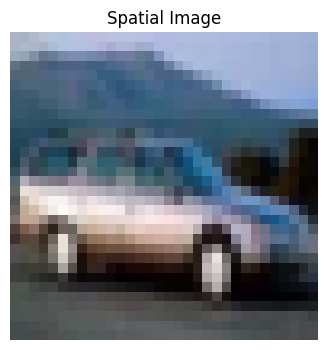

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])
cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

image, label = cifar10_data[4]
image_np = image.numpy()

plt.figure(figsize=(4,4))
plt.title(f"Spatial Image")
plt.axis('off')
plt.imshow(image_np.transpose(1, 2, 0))
plt.show()


Now, we will apply a fourier transform to the spatial image above.


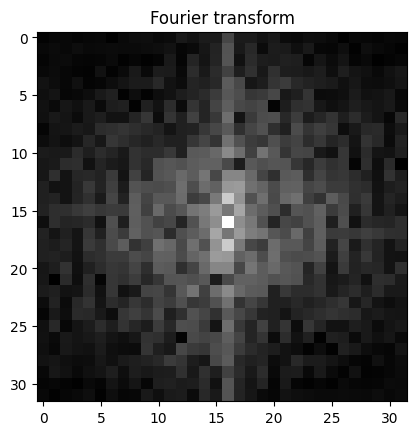

In [ ]:
image_red_channel = image_np[0]
image_tensor = torch.tensor(image_red_channel, dtype=torch.float32)

fft_image = torch.fft.fft2(image_tensor)
fft_image_shifted = torch.fft.fftshift(fft_image)

magnitude_spectrum = torch.abs(fft_image_shifted) #save this instead, save as numpy array
magnitude_spectrum_np = magnitude_spectrum.numpy()


plt.imshow(np.log(1 + magnitude_spectrum_np), cmap='gray')
plt.title("Fourier transform")
plt.show()

To demonstrate that we can use k-space to represent spatial images, we will reconstruct the image using the k-space representation. The expected image will be the image we started with.

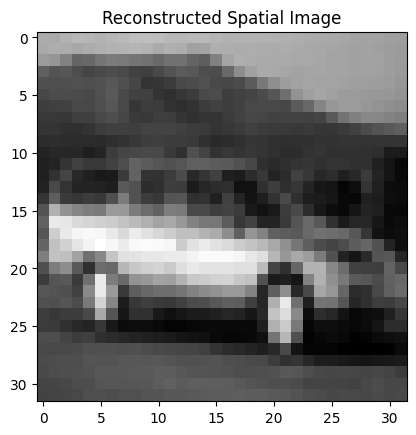

In [ ]:
fft_image_unshifted = torch.fft.ifftshift(fft_image_shifted)
reconstructed_image = torch.fft.ifft2(fft_image_unshifted)
reconstructed_image_real = torch.real(reconstructed_image)
plt.imshow(reconstructed_image_real.numpy(), cmap='gray')
plt.title("Reconstructed Spatial Image")
plt.show()


Below, we iterate through each image in the CIFAR10 dataset and transform them into a k-space image. We first convert the grayscale image into a numpy array and apply a fourier transformation using *torch.fft.fft2(image_tensor)*. We will be using a 2-channel k-space image by combining the real and imaginary values of the matrix to train a CNN on these arrays.These images are stored in an output folder called *cifar_kspace*.

In [ ]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 datasets
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define output folders to save k-space data
output_folder = './cifar_kspace'
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Function to save k-space data
def save_kspace(dataset, folder):
    for i, (image_tensor, label) in enumerate(dataset):

        # Compute k-space using FFT for each channel separately (RGB)
        kspace_channels = []
        for c in range(image_tensor.shape[0]):
            fft_image = torch.fft.fft2(image_tensor[c, :, :])
            fft_image_shifted = torch.fft.fftshift(fft_image)

            real_part = fft_image_shifted.real
            imag_part = fft_image_shifted.imag

            # Stack real and imaginary parts for each channel to form complex representation of the k-space data
            kspace_channels.append(np.stack((real_part.numpy(), imag_part.numpy()), axis=0))

        # Stack all channels (RGB) together
        kspace_image = np.stack(kspace_channels, axis=0)

        # Save as .npz file to store numpy arrays
        file_path = os.path.join(folder, f"image_{i}_label_{label}.npz")
        np.savez(file_path, kspace_image=kspace_image, label=label)

# Save training and testing k-space data
save_kspace(train_data, train_folder)
save_kspace(test_data, test_folder)


Files already downloaded and verified
Files already downloaded and verified


# Training an image classifier on 2-channel k-space images


Now, we will load in the k-space data that we have stored previously and define a CNN model that consists of two convolutional layers, each followed by max pooling, and the network then flattens the feature map and passes it thorugh 3 connected layers. ReLU activation functions are applied after each convolutional and connected layer to introduce non-linearity.

In [ ]:
import torch
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class to load .npz files containing the k-space data and labels using custom data loading logic.
class KSpaceDataset(Dataset):
    def __init__(self, folder):
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npz')]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    #Ensures each file is loaded, and the k-space image is reshaped, normalized, and converted into a tensor in order to fit what the model expects for its input.
    def __getitem__(self, idx):
      file = self.files[idx]
      data = np.load(file)
      kspace_image = data['kspace_image']
      label = int(data['label'])

      kspace_image = kspace_image.reshape(6, 32, 32)
      kspace_image = (kspace_image - kspace_image.mean()) / kspace_image.std()

      kspace_tensor = torch.tensor(kspace_image, dtype=torch.float32)
      return kspace_tensor, label


# Load training and testing data
train_folder = './cifar_kspace/train'
test_folder = './cifar_kspace/test'
train_dataset = KSpaceDataset(train_folder)
test_dataset = KSpaceDataset(test_folder)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defininf the CNN with two convolutional layers followed by three fully connected layers.
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, criterion, and optimizer
net = Net().to(device)
criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) #Stochastic Gradient Descent used to update the model's parameters during training


train_dataset = KSpaceDataset(train_folder)


# Train the network on the training data

We define a training loop for the CNN to classify k-space images. The loop runs 2 epochs and processing the data in mini-batches. In each iteration, the inputs and labels are loaded, and the model then performs a forward pass, computes the loss, and backpropogates the gradients. The model updates the paramters based on these gradients. The running loss is printed for every 200 mini-batches, and plotted onto a loss curve.

[1,   200] loss: 4.407
[1,   400] loss: 3.876
[1,   600] loss: 3.660
[1,   800] loss: 3.462
[1,  1000] loss: 3.334
[1,  1200] loss: 3.215
[1,  1400] loss: 3.185
[2,   200] loss: 3.094
[2,   400] loss: 3.065
[2,   600] loss: 2.970
[2,   800] loss: 2.975
[2,  1000] loss: 2.956
[2,  1200] loss: 2.915
[2,  1400] loss: 2.897
Finished Training


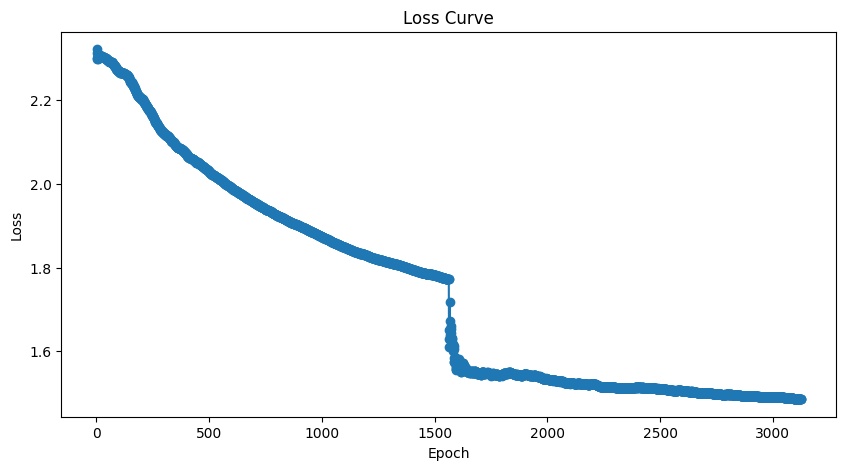

In [ ]:
train_losses = []

for epoch in range(2):

    running_loss = 0.0
    num_batches = 0
    total_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_loss += loss.item()
        num_batches += 1

        #Print loss for every 200 mini-batches
        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

        epoch_loss = total_loss / num_batches
        train_losses.append(epoch_loss)

print('Finished Training')

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker = 'o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()




# Test the network on the test data

Will evaluate the trained CNN on the test data. The model performs a forward pass to compute the outputs, and torch.max is used to get the predicted class by selecting the class with the highest output score. The total number of predictions and the number of correct predictions are tracked, and the accuracy percentage is computed.

In [ ]:

# Evaluate on test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 48.01%


In conclusion, the accuracy of the k-space image classifier of 48.01% is comparable to the 2-channel rgb image classifier of 55%. This can suggest that there is some efficacy to using k-space arrays to train an image classifier.